In [1]:
import numpy as np 
import csv 
import pandas as pd
from scipy.linalg import dft
from scipy import fft
from scipy import ifft
import matplotlib.pyplot as plt 
import bitarray
import pdb
from scipy.io.wavfile import write # For writing to a .wav file
from scipy.io.wavfile import read # For reading from a .wav file to an np array.
from scipy import signal # Module for generating chirp.

In [2]:
# Define constants
N = 1024 #OFDM symbol length
L = 400 #Cyclic prefix length
n = 50 # Number of repetitions of OFDM symbol for transmission
sample_rate = 44100 # Sample rate is 44.1 kHz
chirp_duration = 1
pilot_value = 1+1j # The known value each pilot transmits
FILE_NAME = "clean_input.wav" #name of the file in which we save the pseudo transmitted wave 
pilot_FILE_NAME = 'pilot_' + FILE_NAME
A = 100 #radius of QPSK symbols
chirp_startFrequency = 20
chirp_endFrequency = 20000
introduced_delay = 1000

In [3]:
# Useful helper functions for converting between np arrays and wav files.
def convert_array_to_wav(array, sample_rate, FILE_NAME):
    # Convert the normalized array to a wav file.
    write(FILE_NAME, sample_rate, array)

def convert_wav_to_array(wav_filename):
    rate, array = read(wav_filename)

    return array

## Chirp functions

In [72]:
def generateChirp(startFrequency, endFrequency, sample_rate, duration):
    number_of_samples = int(sample_rate*duration)
    t = list(range(0, number_of_samples+1))
    t = np.array(t)
    t = t / sample_rate
    chirp = signal.chirp(t, startFrequency, duration, endFrequency, method='linear')

    return chirp

def matched_filter(noisy_signal, desired_signal):
    desired_signal = desired_signal.flatten()
    
    correlation = signal.correlate(noisy_signal, desired_signal, mode='same')
    x = np.arange(len(correlation))
    
    max_correlation = np.amax(correlation)
    max_correlation_index = np.argmax(correlation)

    fig, ax = plt.subplots()
    plt.title("Matched filtering")
    plt.xlabel("Sample")
    plt.xlim(max_correlation_index - 50, max_correlation_index + 50)
    plt.ylabel("Correlation between chirp and noisy received signal - amplitude")

    ax.plot(x, correlation)
    fig.show()
    
    
    return max_correlation_index

def find_delay(received_signal, chirp_signal):
    max_corr_index = matched_filter(chirp_signal, chirp_signal)
    max_corr_index_delay = matched_filter(received_signal, chirp_signal)
    
    return max_corr_index_delay - max_corr_index 

#### Generate random transmitted signal with chirp at the beginning

In [73]:
# Need to fix this, block size gives error with large integer
def generate_random_indices(block_size):
    """Generates numpy array of random indices with seed '2021' such that random array is predictable"""
    seed = 2021 # Standardise random number generator seed as 2021, which I arbitrarily selected
    rng = np.random.default_rng(seed) # Random number generator with specified seed
    random_constellation_indices = rng.integers(low=0, high=4, size=block_size) # Generate 511 random indices for the QPSK constellation

    return random_constellation_indices

# Generate an array of 511 random constellation symbols with '0' as the first element.
# 'A' is the radius of the QPSK constellation circle.

def generate_random_sequence(N, QPSK=True):
    """Takes the size of OFDM symbol length, assuming QPSK encoding and returns array of random constellation symbols"""
    block_size = int(N / 2 - 1) # Set size of block to OFDM symbol length divided by 2 for mirroring and subtract 1 to have zeroed first entry
    mapping = A/np.sqrt(2) * np.array([(1+1j), (-1+1j), (-1-1j), (1-1j)]) # Define the mapping of indices to QPSK constellation
    
    random_constellation_indices = generate_random_indices(block_size)
    random_sequence = np.array([0]) # Set up first element to be constellation symbol corresponding to zero
    for index in random_constellation_indices:
        random_sequence = np.append(random_sequence, mapping[index])

    return random_sequence
  
# Takes an array and appends the flipped/reversed complex-conjugate array. The two concatenated arrays both begin with a '0'.
def generate_symmetric_sequence(sequence):
    """Takes a array sequence and appends a reversed form on the end"""
    reversed_sequence = np.conj(np.append(np.array([0]), np.flip(sequence[1:int(N/2)]))) # Reverse the order of the input array, and take the complex conjugate.
    symmetric_sequence = np.append(sequence, reversed_sequence) # Append the flipped array to the original array.
    return symmetric_sequence


# Take N-point iDFT of an array, to be used carefully! This function should probably be named differently!!!
def apply_inverse_dft(sequence):
    """Takes a N-point inverse discrete Fourier transform of a sequence, who's output is purely real"""
    OFDM_TX_noCP = ifft(sequence) # Take inverse discrete Fourier transform
    assert np.amax(OFDM_TX_noCP.imag) < 1, "Input sequence in frequencey domain is not symmetric so time domain is not purely real"

    OFDM_TX_noCP = OFDM_TX_noCP.real # Consider only real part given that it is supposed to be real
    return OFDM_TX_noCP

# Add cyclic prefix
def add_cyclic_prefix(sequence, N, L):
    """Takes sequence, the symbol length and cyclic prefix length L to insert cyclic prefix"""
    cyclic_prefix = sequence[-L:] # Generate cyclic prefix by taking last values
    OFDM_TX_withCP = np.append(cyclic_prefix, sequence) # Create single OFDM symbol by joining cyclic prefix and sequence
    return OFDM_TX_withCP

# Create the array to be transmitted by repeating the above OFDM symbol some number of times. (And including any elements needed for synchronization).
def generate_repeated_signal(OFDM_TX_withCP, n):
    """Generate signal to be transmitted by repeating the OFDM symbol n times"""
    repeated_signal = np.array([]) # Repeats OFDM symbol n times
    for i in range(0,n):
        repeated_signal = np.append(repeated_signal, OFDM_TX_withCP)
    return repeated_signal

def generate_signal_for_estimation(N, n, FILE_NAME, use_chirp=True):
    """The 'master' function that takes the block length N"""
    
    # (In time domain)
    if use_chirp:
        chirp_signal = generateChirp(chirp_startFrequency, chirp_endFrequency, sample_rate, chirp_duration) # Generate chirp signal for start of transmission
    
    # (In frequency domain)
    random_sequence = generate_random_sequence(N) # Generate random but predictable seqeunce which (length N/2)
    symmetric_sequence = generate_symmetric_sequence(random_sequence) # Create symmetric sequence to make transmitted OFDM symbol real (length N)

    # (In time domain)
    OFDM_TX_noCP = apply_inverse_dft(symmetric_sequence) # Apply the inverse DFT to generate time_domain OFDM symbol without cyclic prefix (length N)
    OFDM_TX_withCP = add_cyclic_prefix(OFDM_TX_noCP, N, L) # Insert cyclic prefix to create OFDM symbol (length N+L)
    repeated_signal = generate_repeated_signal(OFDM_TX_withCP, n) # Repeat OFDM symbol n times (length n*(N+L))
    transmitted_signal = np.append(chirp_signal, repeated_signal) # Create transmitted signal by inserting chirp at start (length chirp_length n*(N+L))
    
    # Plot the transmitted signal
    t = list(range(1, len(transmitted_signal)+1))
    times = np.array(t)
    #times = times / sample_rate
    x = times
    fig, ax = plt.subplots()
    plt.title("Transmitted Signal")
    plt.xlabel("Sample")
    plt.ylabel("Transmitted Signal Magnitude")
    plt.axvline(x=0) #Should be at beginning of chirp
    plt.axvline(x=22050) #Should be at end of chirp
    # plt.xlim(0, 1000)
    #plt.ylim(-1.1, 1.1)
    ax.plot(x, transmitted_signal)
    fig.show()
    
    convert_array_to_wav(transmitted_signal, sample_rate, FILE_NAME)

    return transmitted_signal

# Receiver side - synchronization and estimation

In [90]:
# Functions mainly for use in receiver.

# Calculates the delay present at the receiver in terms of indices in the arrays
# by applying the matched filter to the received signal.
def find_delay(received_signal, chirp_signal):
    max_corr_index = matched_filter(chirp_signal, chirp_signal)
    max_corr_index_delay = matched_filter(received_signal, chirp_signal)
    
    return max_corr_index_delay - max_corr_index


# Shift the received array left by the amount of the delay. (A certain number of elements) Also cut the array where we expect the transmitted sequency to end.
def calculate_received_signal_without_delay(received_signal, chirp_signal):
    """Takes the received signal and the chirp, to remove the delay and perform synchronisation"""
    delay = find_delay(received_signal, chirp_signal) # Calculate delay

    chirp_length = len(chirp_signal) # Find length of chirp signal
    received_signal_without_delay = received_signal[delay+chirp_length:delay+chirp_length+(n*(N+L))] # Using calculated delay, remove the delay

    return received_signal_without_delay

# Remove cyclic prefix
def removeCP(signal):
    """Remove the cyclic prefix of a signal"""
    # to do: adjust for the whole signal, not just one ofdm block
    return signal[L:(L+N)]

def DFT(OFDM_RX):
    """Compute the discrete Fourier transform of the received OFDM symbol"""
    return fft(OFDM_RX)

def compute_average(two_dimensional_array, N, n):
    """
    Computes the average of a two-dimensional array, element-wise.
    Needs the length of the 'block' N and the number of blocks n.
    For example, inputting np.array([[0,1,2],[2,3,4]]) would return np.array([1,2,3]).
    Note, we call each individual array a 'block' so we are just averaging over them.
    (There should be a nicer 'numpyier' 'vectorised' way of doing this better, try later)
    """
    sum_of_blocks = np.zeros(N) # Initialise as zeros array for summing each block of two-dimensional array
    for block in two_dimensional_array:
        sum_of_blocks = sum_of_blocks + block # Compute sum of each block all together
    average_block = sum_of_blocks / n # Take average by dividing by number of blocks
    return average_block

def compute_average_symbol(received_signal):
    """Takes the received signal without delay, computes the average received OFDM symbol without cyclic prefix, then takes DFT to return in frequency domain"""
    # (In time domain)
    received_signal = np.split(received_signal, n) # Split up received signal into blocks
    OFDM_RX_noCP = [removeCP(received_block) for received_block in received_signal] # Remove cyclic prefix
    OFDM_RX_noCP_average = compute_average(OFDM_RX_noCP, N, n) # Computes the average received block without cyclic prefix
    
    # Note that beyond this point, we are dealing with an 'averaged' block in the time domain because of previous step
    
    # (In frequency domain)
    OFDM_RX_demod_average = DFT(OFDM_RX_noCP_average) # Compute DFT of received signal without cyclic prefix
    
    return OFDM_RX_demod_average

def estimate_channel_frequency_response(OFDM_RX_demod_average, transmitted_block): #transmitted block is known from before
    """
    Takes the demodulated received OFDM sequence and the initially transmitted block.
    Estimates the channel frequency response by division.
    """
    
    # (In frequency domain)
    # Some checks which can be removed later
    #print(np.shape(OFDM_RX_demod_average[1:int(N/2)])) # Only take first postiive 'real' half and ignore zero at start
    #print(np.shape(transmitted_block[1:])) # Ignore first value which is zero to avoid dividing by zero

    H_est = OFDM_RX_demod_average[1:int(N/2)] / transmitted_block[1:] # divide second half of averaged demodulated block by the transmitted pilot values
    #print(np.shape(H_est))
    #H_est_abs = abs(H_est) # Compute amplitude of frequency response
    #H_est_phase = np.angle(H_est) # Compute amplitude of frequency response
    return H_est


def compute_channel_impulse_response(H_est):
    # (In frequency domain)
    H_est_symmetric = generate_symmetric_sequence(H_est)
    
    # (In time domain)
    h_time = apply_inverse_dft(H_est_symmetric)
    return h_time

def estimate_channel(input_audio_filename):
    """
    'Master' function to estimate the channel impulse response in time domain
    """
    # (In time domain)
    received_signal = convert_wav_to_array(input_audio_filename) # Convert received .wav file to an np array.
    received_signal_without_delay = received_signal
    #print(received_signal)
    #seed = 2021
    #rng = np.random.default_rng(seed)
    #received_signal = np.append(rng.random(100), received_signal)
    #chirp_signal = generateChirp(chirp_startFrequency, chirp_endFrequency, sample_rate, chirp_duration)
    #received_signal_without_delay = calculate_received_signal_without_delay(received_signal, chirp_signal) # Perform synchronisation by removing time delay
    #print(received_signal_without_delay)
    # (In frequency domain)
    OFDM_RX_demod_average = compute_average_symbol(received_signal_without_delay) # Compute the average demodulated OFDM sequence
    H_est = estimate_channel_frequency_response(OFDM_RX_demod_average, generate_random_sequence(N)) # Be careful that random sequence is the same from earlier

    # (In time domain)
    h_time = compute_channel_impulse_response(H_est) #
    return h_time, H_est

def plot_channel_response(h_est, H_est):
    t = list(range(1, len(h_est)+1))
    times = np.array(t)
    #times = times / sample_rate
    x = times
    fig, ax = plt.subplots()
    plt.title("Estimated Channel Impulse Response")
    plt.xlabel("Sample")
    plt.ylabel("Impulse Response Magnitude")
    ax.plot(x, h_est)
    fig.show()

    f = list(range(1, len(H_est)+1))
    frequencies = np.array(f)
    frequencies = (sample_rate / N) * frequencies
    x = frequencies
    fig, ax = plt.subplots()
    plt.title('Magnitude of DFT of Channel Impulse Response estimated using repeated random OFDM symbols')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Relative Amplitude')
    plt.yscale('log')
    ax.plot(x, abs(H_est))
    fig.show()

# Testing

#### Tranmitted signal is the generated signal, delayed, noise corrupted and passed through channel: SYNCH testing

1002
71200


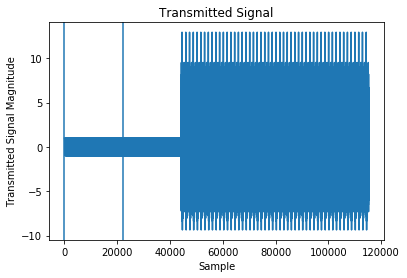

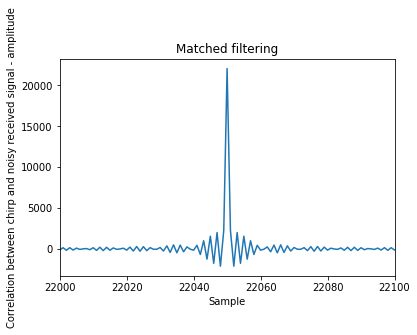

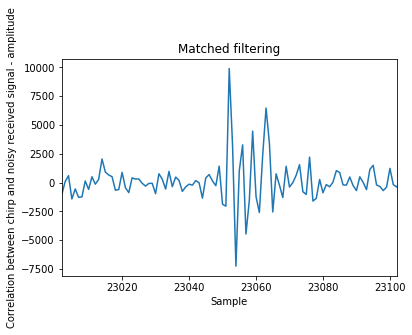

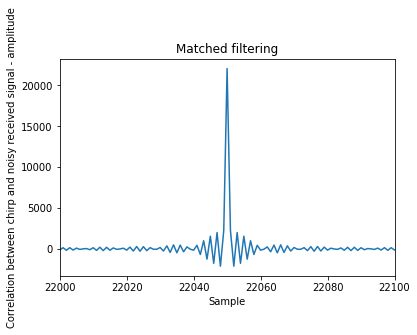

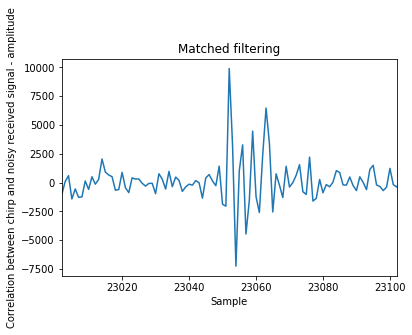

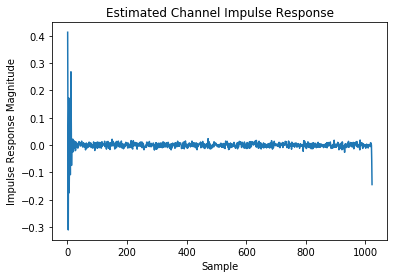

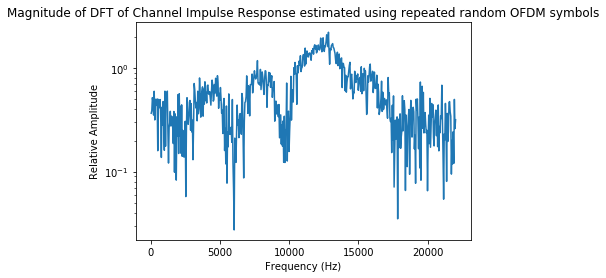

In [92]:
transmitted_signal = generate_signal_for_estimation(N, n, FILE_NAME)


channelResponse = pd.read_csv('channel.csv')
zero_array = np.zeros(len(transmitted_signal) - len(channelResponse))
channelResponse = np.append(channelResponse, zero_array)

chirp_signal = generateChirp(chirp_startFrequency, chirp_endFrequency, sample_rate, chirp_duration)
receiver_signal = signal.convolve(channelResponse, transmitted_signal, mode='full')
receiver_signal = np.append(np.zeros(introduced_delay), receiver_signal)
white_noise = np.random.normal(0, 5, len(receiver_signal))
receiver_signal = receiver_signal + white_noise


delay = find_delay(receiver_signal, chirp_signal)
print(delay)


signal_without_delay = calculate_received_signal_without_delay(receiver_signal, chirp_signal)
print(len(signal_without_delay))

convert_array_to_wav(signal_without_delay, sample_rate, 'signal_without_delay.wav')

h_est, H_est = estimate_channel('signal_without_delay.wav')


plot_channel_response(h_est, H_est)

71200


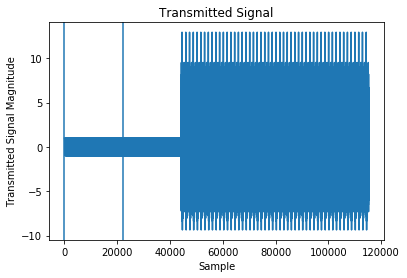

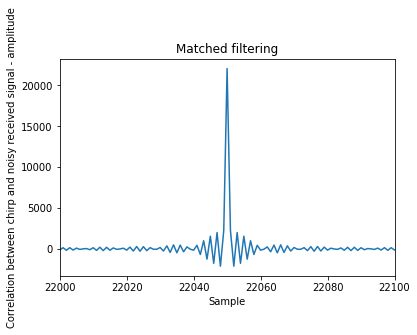

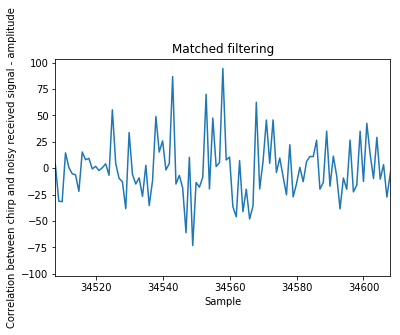

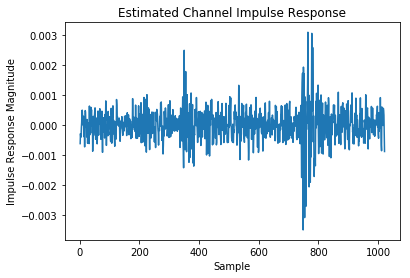

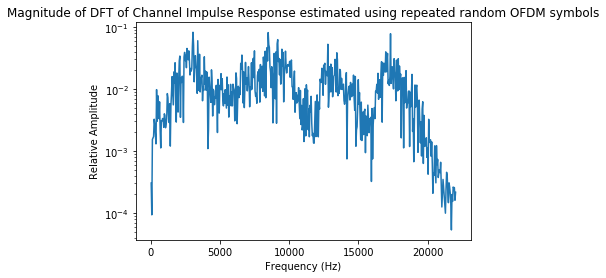

In [97]:
transmitted_signal = generate_signal_for_estimation(N, n, FILE_NAME)

receiver_signal = convert_wav_to_array('output.wav')

signal_without_delay = calculate_received_signal_without_delay(receiver_signal, chirp_signal)
print(len(signal_without_delay))


convert_array_to_wav(signal_without_delay, sample_rate, 'signal_without_delay.wav')

h_est, H_est = estimate_channel('signal_without_delay.wav')


plot_channel_response(h_est, H_est)

In [89]:
def plot_channel_response(h_est, H_est):
    t = list(range(1, len(h_est)+1))
    times = np.array(t)
    #times = times / sample_rate
    x = times
    fig, ax = plt.subplots()
    plt.title("Estimated Channel Impulse Response")
    plt.xlabel("Sample")
    plt.ylabel("Impulse Response Magnitude")
    ax.plot(x, h_est)
    fig.show()

    f = list(range(1, len(H_est)+1))
    frequencies = np.array(f)
    frequencies = (sample_rate / N) * frequencies
    x = frequencies
    fig, ax = plt.subplots()
    plt.title('Magnitude of DFT of Channel Impulse Response estimated using repeated random OFDM symbols')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Relative Amplitude')
    plt.yscale('log')
    ax.plot(x, abs(H_est))
    fig.show()

1002


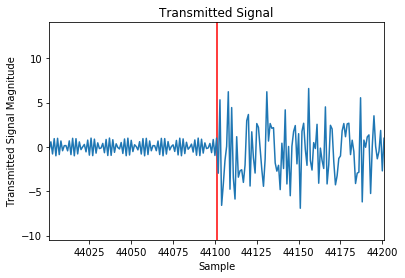

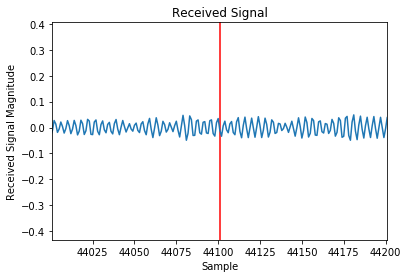

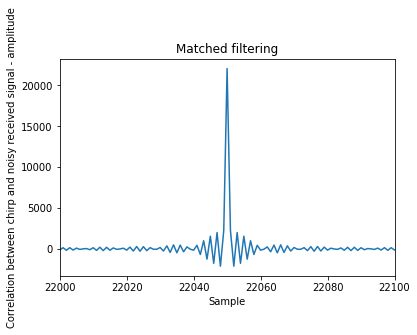

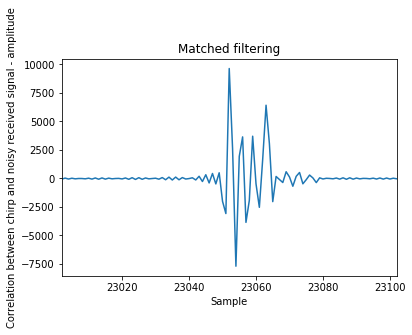

In [77]:
received_signal = convert_wav_to_array('output.wav')
transmitted_signal = convert_wav_to_array(FILE_NAME)

# Plot the transmitted signal
t = list(range(1, len(transmitted_signal)+1))
times = np.array(t)
x = times
fig, ax = plt.subplots()
plt.title("Transmitted Signal")
plt.xlabel("Sample")
plt.ylabel("Transmitted Signal Magnitude")
plt.axvline(x=0) #Should be at beginning of chirp
chirp_length = len(chirp_signal)
plt.axvline(x=chirp_length, color = 'red') #Should be at end of chirp
plt.xlim(chirp_length - 100, chirp_length + 100)
#plt.ylim(-1.1, 1.1)
ax.plot(x, transmitted_signal)
fig.show()

# Plot the received signal
t = list(range(1, len(received_signal)+1))
times = np.array(t)
x = times
fig, ax = plt.subplots()
plt.title("Received Signal")
plt.xlabel("Sample")
plt.ylabel("Received Signal Magnitude")
plt.axvline(x=0) #Should be at beginning of chirp
chirp_length = len(chirp_signal)
plt.axvline(x=chirp_length, color = 'red') #Should be at end of chirp
plt.xlim(chirp_length - 100, chirp_length + 100)
#plt.ylim(-1.1, 1.1)
ax.plot(x, received_signal)
fig.show()

delay = find_delay(receiver_signal, chirp_signal)
print(delay)

### Chirp + random signal; delayed and noise corrupted 

(1000, 23050)


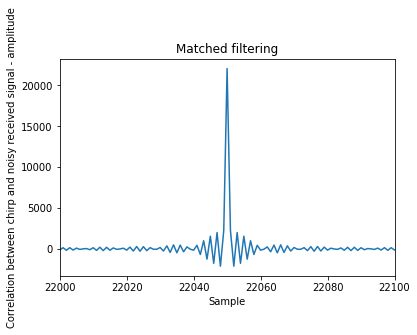

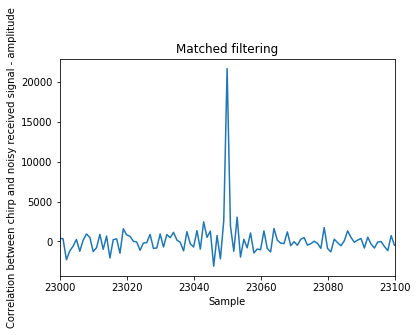

In [19]:
chirp_signal = generateChirp(chirp_startFrequency, chirp_endFrequency, sample_rate, chirp_duration)

#delay signal 
chirp_delay_noise = np.append(np.zeros(introduced_delay), chirp_signal)

#add random signal 
seed = 2021
rng = np.random.default_rng(seed) # Random number generator with specified seed
random_signal = rng.integers(low=0, high=4, size=1024)

chirp_delay_noise = np.append(chirp_delay_noise, random_signal)

#corrupt with noise
white_noise = np.random.normal(0, 5, len(chirp_delay_noise))
chirp_delay_noise = chirp_delay_noise + white_noise

print(find_delay(chirp_delay_noise, chirp_signal))



### Chirp + random signal; delayed and noise corrupted + PASSED THROUGH CHANNEL 

1002


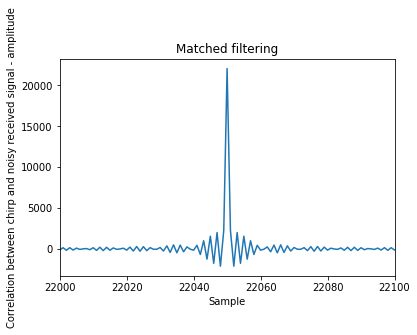

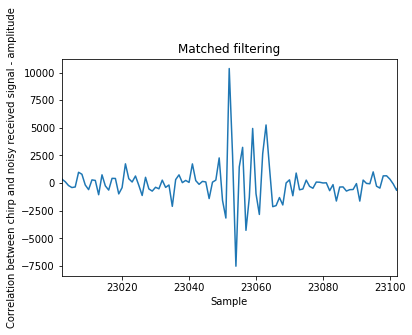

In [22]:
chirp_signal = generateChirp(chirp_startFrequency, chirp_endFrequency, sample_rate, chirp_duration)


#add random signal 
seed = 2021
rng = np.random.default_rng(seed) # Random number generator with specified seed
random_signal = rng.integers(low=0, high=4, size=70000)

chirp_delay_noise = np.append(chirp_signal, random_signal)

channelResponse = pd.read_csv('channel.csv')
zero_array = np.zeros(len(chirp_delay_noise) - len(channelResponse))
channelResponse = np.append(channelResponse, zero_array)



receiver_signal = signal.convolve(channelResponse, chirp_delay_noise, mode='full')
receiver_signal = np.append(np.zeros(introduced_delay), receiver_signal)


#corrupt with noise
white_noise = np.random.normal(0, 5, len(receiver_signal))
receiver_signal = receiver_signal + white_noise


delay, ind = find_delay(receiver_signal, chirp_signal)
print(delay)


In [52]:
# Need to fix this, block size gives error with large integer
def generate_random_indices(block_size):
    """Generates numpy array of random indices with seed '2021' such that random array is predictable"""
    seed = 2021 # Standardise random number generator seed as 2021, which I arbitrarily selected
    rng = np.random.default_rng(seed) # Random number generator with specified seed
    random_constellation_indices = rng.integers(low=0, high=4, size=block_size) # Generate 511 random indices for the QPSK constellation

    return random_constellation_indices

# Generate an array of 511 random constellation symbols with '0' as the first element.
# 'A' is the radius of the QPSK constellation circle.

def generate_random_sequence(N, QPSK=True):
    """Takes the size of OFDM symbol length, assuming QPSK encoding and returns array of random constellation symbols"""
    block_size = int(N / 2 - 1) # Set size of block to OFDM symbol length divided by 2 for mirroring and subtract 1 to have zeroed first entry
    mapping = A/np.sqrt(2) * np.array([(1+1j), (-1+1j), (-1-1j), (1-1j)]) # Define the mapping of indices to QPSK constellation
    
    random_constellation_indices = generate_random_indices(block_size)
    random_sequence = np.array([0]) # Set up first element to be constellation symbol corresponding to zero
    for index in random_constellation_indices:
        random_sequence = np.append(random_sequence, mapping[index])

    return random_sequence
  
# Takes an array and appends the flipped/reversed complex-conjugate array. The two concatenated arrays both begin with a '0'.
def generate_symmetric_sequence(sequence):
    """Takes a array sequence and appends a reversed form on the end"""
    reversed_sequence = np.conj(np.append(np.array([0]), np.flip(sequence[1:int(N/2)]))) # Reverse the order of the input array, and take the complex conjugate.
    symmetric_sequence = np.append(sequence, reversed_sequence) # Append the flipped array to the original array.
    return symmetric_sequence


In [53]:
random_const_indices = generate_random_indices(N)

In [54]:
random_sequence = generate_random_sequence(N)

In [55]:
symmetric_sequence = generate_symmetric_sequence(random_sequence)

In [56]:
print(symmetric_sequence)

[  0.         +0.j          70.71067812-70.71067812j
  70.71067812-70.71067812j ... -70.71067812-70.71067812j
  70.71067812+70.71067812j  70.71067812+70.71067812j]
